
#               Machine learning for finance 

### 1. Download and Feature Engineer

For now let's keep it simple:
• 3 tickers - just for exploring the idea
• yfinance - free daily data
• 3 features - Close prices, range (%), open to close (%)

You can experiment with other features & instruments later

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf

In [2]:
#%conda install -c conda-forge yfinance

In [1]:
#conda update -n base -c defaults conda

In [4]:
tickers = ['AMZN', 'MSFT', 'NVDA']

dfs = []

for ticker in tickers:
    df = yf.download(ticker).reset_index()
    df['range'] = df['High']/df['Low'] -1
    df['open_to_close'] = df['Close']/df['Open'] -1
    df['ticker'] = ticker
    
    dfs.append(df)
    
df = pd.concat(dfs).reset_index(drop = True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### 2. Feature Reshaping

* Time series algos require data in the shape =  (example #, feature length, feature #)


* Also, I assume that adjacent examples split apart by one day will be similar - therefore, let's undersample by selecting every   5th row.

  This may save us some training time and still retain most of the variance in the examples.
  


In [8]:
feature_length = 50
feature_cols = ['Close', 'range', 'open_to_close']

def time_series(df, col, name):
    '''
    form the lagges column fo this feature
    '''
    return df.assign(**{
        f'{name}_t-{lag}': col.shift(lag)
        for lag in range(0, feature_length)
    })

feature_dfs = []

for ticker in tickers:
    df_ticker = df[df['ticker'] == ticker].copy()
    
    for col in feature_cols:
        df_ticker = time_series(df_ticker, df_ticker[col], f'feat_{col}')
        
    #if any infinite value slips in, replace them with nan and drop all nan rows
    df_ticker = df_ticker.replace({-np.inf:np.nan, np.inf:np.nan})
    df_ticker = df_ticker.dropna().reset_index(drop = True)
                                
    #since adjoining days will have similar pattern, lets keep only every fifth case
    df_ticker = df_ticker.iloc[::5]
                                
    feature_dfs.append(df_ticker)
                                
feature_df = pd.concat(feature_dfs)
                                
print('Number of samples in the entire dataset: ', feature_df.shape[0])

feature_df.head()

Number of samples in the entire dataset:  4464


,Date,Open,High,Low,Close,Adj Close,Volume,range,open_to_close,ticker,...,feat_open_to_close_t-40,feat_open_to_close_t-41,feat_open_to_close_t-42,feat_open_to_close_t-43,feat_open_to_close_t-44,feat_open_to_close_t-45,feat_open_to_close_t-46,feat_open_to_close_t-47,feat_open_to_close_t-48,feat_open_to_close_t-49
0,1997-07-25,0.110938,0.112500,0.110938,0.111458,0.111458,12408000,0.014080,0.004687,AMZN,...,-0.023650,-0.057686,0.048278,0.066659,-0.028981,-0.127392,-0.054211,-0.029584,-0.121701,-0.196578
5,1997-08-01,0.117188,0.120833,0.112500,0.120833,0.120833,71760000,0.074071,0.031104,AMZN,...,0.088236,-0.042254,-0.034024,0.000000,0.000000,-0.023650,-0.057686,0.048278,0.066659,-0.028981
10,1997-08-08,0.108333,0.115104,0.105208,0.114583,0.114583,44232000,0.094061,0.057692,AMZN,...,0.013149,-0.032690,-0.073170,0.018862,0.092794,0.088236,-0.042254,-0.034024,0.000000,0.000000
15,1997-08-15,0.106771,0.107813,0.096875,0.105729,0.105729,31944000,0.112908,-0.009759,AMZN,...,0.000000,-0.006851,-0.058638,-0.019474,-0.025637,0.013149,-0.032690,-0.073170,0.018862,0.092794
20,1997-08-22,0.105208,0.106250,0.104688,0.106250,0.106250,14256000,0.014921,0.009904,AMZN,...,-0.006851,-0.010236,0.003468,-0.027023,-0.003409,0.000000,-0.006851,-0.058638,-0.019474,-0.025637


* With all these new cols, we now need to reshape into a 3D array

  This is achieved with the attached code

  I will say, this whole reshaping nonsense is tricky to wrap your head around! So don't worry if it's not immediately obvious    🙂

In [11]:
def reshape_features_for_clustering(feat_arr_2d, feat_length):
    
    feat_arrs = []
    
    for n in range(0, feat_arr_2d.shape[1]//feat_length):
        
        feat_arrs.append(
        np.fliplr(feat_arr_2d[:, n*feat_length:(n+1)*feat_length])
        )
    
    feats_3d = np.dstack(feat_arrs)
    
    return feats_3d

feat_cols = [col for col in feature_df.columns  if 'feat' in col]
train_until = '2019-01-01'

df_train = feature_df[feature_df['Date'] < train_until].reset_index(drop = True)

x_train = reshape_features_for_clustering(df_train[feat_cols].values,
                                         feature_length)

df_test = feature_df[feature_df['Date'] >= train_until].reset_index(drop = True)

x_test = reshape_features_for_clustering(df_test[feat_cols].values,
                                         feature_length)

print('shape of x_train:', x_train.shape)
print('shape of x_test:', x_test.shape)

shape of x_train: (3717, 50, 3)
shape of x_test: (747, 50, 3)


### 3. Scaling

Two of our features are % changes -> already scaled.

However, closing prices are not scaled!

Why do we need to scale?

We're aiming to say "this time series is similar to that one" - it could be tricky to judge this if they're completely different on price scales.

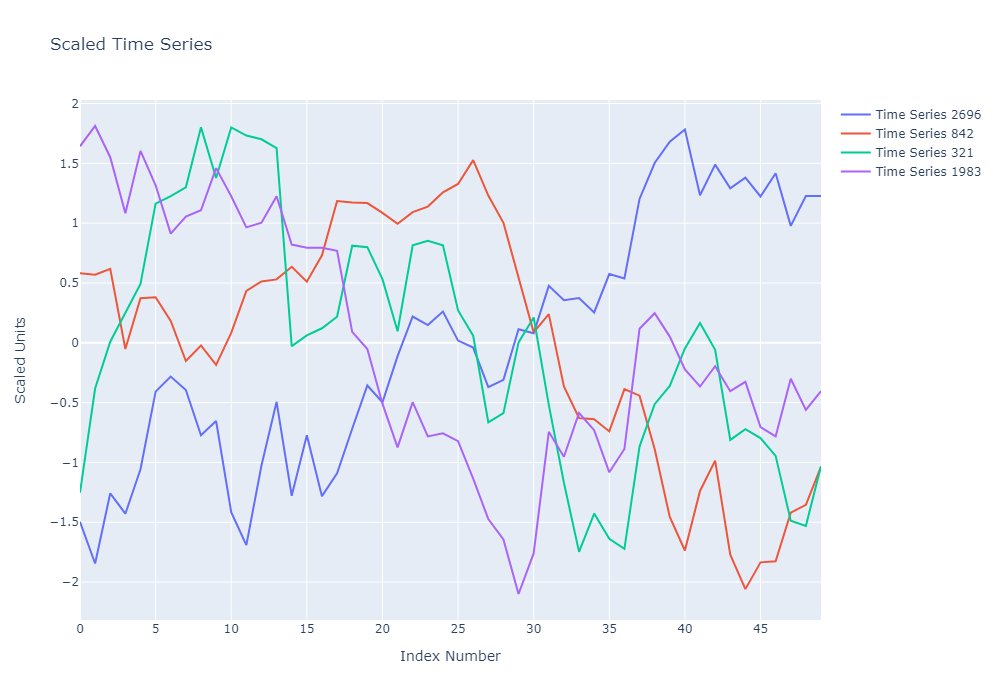 

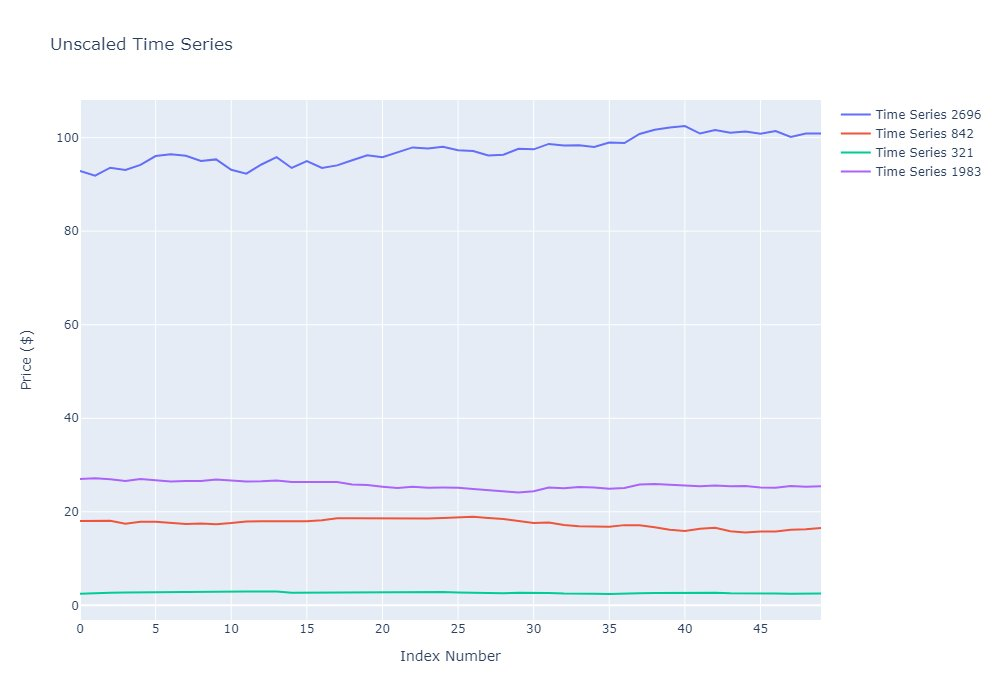

### 3a. Scaling

Once prices are on the same scale, seeing if one curve looks like another is easier

Since our goal is to find time-series similarity, scaling is a good idea

How do we scale?

Let's use standard scaling - the time series have a mean of 0 and standard deviation of 1

In [12]:
def standard_scale(x):
    
    mean = x.mean(axis = 1, keepdims = 1)
    std = x.std(axis = 1, keepdims = 1)
    
    x = (x - mean)/std
    
    #replace infinity with a large finite value
    x[x == np.inf] = 1e9
    x[x == -np.inf] = -1e9
    
    return x

#scale only the close time series, which is the first feature in the 3d array
x_train_scaled = x_train.copy()
x_train_scaled[:,:,0] = standard_scale(x_train[:,:,0])

x_test_scaled = x_test.copy()
x_test_scaled[:,:,0] = standard_scale(x_test[:,:,0])

### 3b. Scaling

Why this approach?

It tends to be a little less sensitive to outliers.

But at the end of the day, it's worth trying other ways too - because they could be better for your particular problem.

### 4. Clustering

Clustering is basically a way to sort data into groups.

However, we decide how many groups we want before we start 

Therefore, the big question is - how many groups do we need?

In [14]:
#!pip install kneed

In [16]:
#!pip install tslearn

In [19]:
import time
from kneed import KneeLocator
#from tslearn.clustering import TimeSeriesKmeans
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tslearn.clustering.TimeSeriesKMeans'

In [17]:
distance = []

clustering = []

t0 = time.time()
k_range = range(2,15)

for k in k_range:
    
    cluster_t0 = time.time()
    
    print('Clustering with k =', k)
    
    kmeans = TimeSeriesKmeans(
    n_clusters = k,
    metric = 'euclidean',
    random_state = 42,
    n_jobs = -1)
    
    kmeans.fit(x_trained_scaled)
    
    clusterings.append(kmeans)
    distance.append(kmeans.inertia_)
    
    print('Inertia:', kmeans.inertia_)
    print('Time Taken:', time.time() - cluster_t0)
    print('')
    
    
print('Overall fitting time:', time.time() - t0)

elbow_locator = KneeLocator(k_range, distance, curve = 'convex', direction = 'decreasing')
optimal_k = elbow_locator.elbow

print(f'\n Optimal k: {optimal_k}')

plt.plot(k_range, distance, marker = 'o')
plt.title('Elbow method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

Clustering with k = 2


NameError: name 'TimeSeriesKmeans' is not defined